## Notebook Imports

In [111]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

## Constants

In [112]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2/'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'

# For categories
SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [113]:
# Reading the file
stream = open(EXAMPLE_FILE, encoding='latin-1')

# Reading file context line by line
message = stream.read()

# Close stream after reading
stream.close()

In [114]:
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [115]:
import sys

In [116]:
sys.getfilesystemencoding()

'utf-8'

In [117]:
# To read only message body
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

# Read all lines in file
for line in stream:
    if is_body:
        lines.append(line)
    
    # To detect a line space between header and a body
    elif line == '\n':
        is_body = True


stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Functions

In [118]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [119]:
for i in generate_squares(5):
    print(i, end='-> ')

0-> 1-> 4-> 9-> 16-> 

## Email body extraction

In [120]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            # Extracts email from a particular file
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            # Read all lines in a file
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True


            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [121]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [122]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.tail()

,MESSAGE,CATEGORY
01311.43bfe86df65d53c5f7ca2365dc12582b,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00851.dc5452f80ba0bb8481dfc48f70380c4d,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,1
01328.b23902de23cb3ca1f3334517282372b2,Hello:\n\n\n\nAre you satisfied with your ISP?...,1
01244.9ef966101737a6fc27d8965def288d70,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,1
00788.b98a23c07d59156d172683fc29b80661,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,1


In [123]:
spam_emails.shape

(1898, 2)

In [124]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


In [125]:
ham_emails.shape

(3901, 2)

In [126]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is:', data.shape)
data.head()

Shape of entire dataframe is: (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [127]:
data.tail()

,MESSAGE,CATEGORY
00609.dd49926ce94a1ea328cce9b62825bc97,"I'm one of the 30,000 but it's not working ver...",0
00957.e0b56b117f3ec5f85e432a9d2a47801f,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0
01127.841233b48eceb74a825417d8d918abf8,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0
01178.5c977dff972cd6eef64d4173b90307f0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0
00747.352d424267d36975a7b40b85ffd0885e,"If you run Pick, and then use the ""New FTOC"" b...",0


## Data Cleaning: Checking for Missing Values

In [128]:
# Check if any message body is null
data['MESSAGE'].isnull().values.any()

False

In [129]:
# Check if there are empty emails (String len zero)
(data.MESSAGE.str.len() == 0).any()

True

In [130]:
# Count how many are empty str
(data.MESSAGE.str.len() == 0).sum()

3

In [131]:
# Check number of entries with null/none values?
# Will return 0, because it is considering empty str also
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [132]:
# Return index names where it is zero
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [133]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

### Remove System Files Entries from Dataframe

In [134]:
data = data.drop('cmds')
data.shape

(5796, 2)

### Add Document IDs to track Emails in Dataset

In [135]:
document_ids = range(0, len(data.index))

# Adding new col for DOC_ID
data['DOC_ID'] = document_ids

In [136]:
# Adding a new col for FILE_NAMES(index)
data['FILE_NAMES'] = data.index
data.head()

,MESSAGE,CATEGORY,DOC_ID,FILE_NAMES
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,0,00249.5f45607c1bffe89f60ba1ec9f878039a
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1,1,00373.ebe8670ac56b04125c25100a36ab0510
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1,2,00214.1367039e50dc6b7adb0f2aa8aba83216
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,3,00210.050ffd105bd4e006771ee63cabc59978
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1,4,00033.9babb58d9298daa2963d4f514193d7d6


In [137]:
# Replacing index from filenames to 'DOC_ID'
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [138]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
5791,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8
5794,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,01178.5c977dff972cd6eef64d4173b90307f0
5795,"If you run Pick, and then use the ""New FTOC"" b...",0,00747.352d424267d36975a7b40b85ffd0885e


## Save to File using Pandas

In [139]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualized (Pie Charts)

In [140]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [141]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

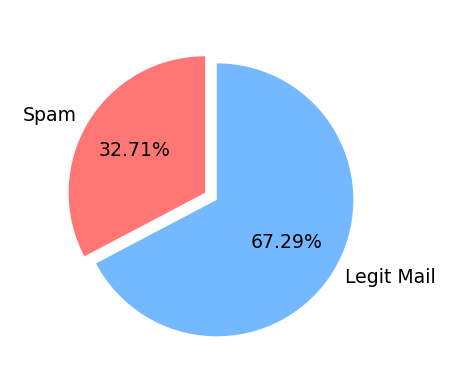

In [142]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=226)   #dpi=display pixel per inch
plt.pie(sizes, labels=category_names,
        textprops={'fontsize': 6}, startangle=90,  #startangle = rotate pie
        autopct='%1.2f%%', colors=custom_colours,  #autopct = format for % label
        explode=[0,0.1])    # explode =distance of pie slice
plt.show()

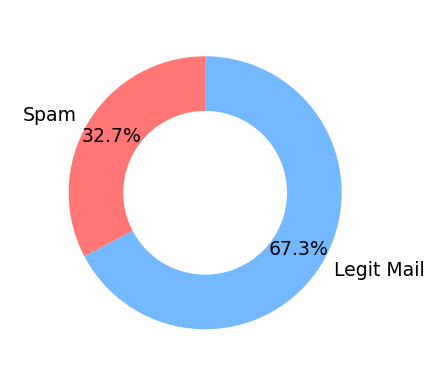

In [143]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=226)   #dpi=display pixel per inch
plt.pie(sizes, labels=category_names,
        textprops={'fontsize': 6}, startangle=90,  #startangle = rotate pie
        autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8)  #Percent label moving out

#Add a circle as a donut illusion to the center of pie chart
centre_circle = plt.Circle((0,0), radius=0.6, fc='white') #Give coordinates and radius
plt.gca().add_artist(centre_circle)   #gca = get_current_axis


plt.show()

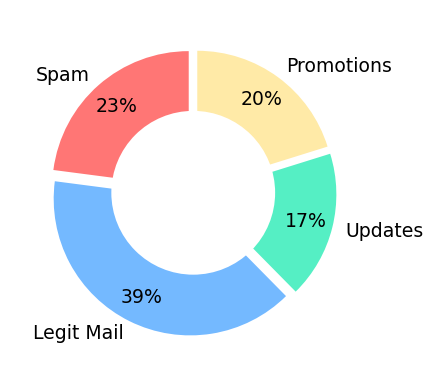

In [144]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=226)   #dpi=display pixel per inch
plt.pie(sizes, labels=category_names,
        textprops={'fontsize': 6}, startangle=90,  #startangle = rotate pie
        autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8,  #Percent label moving out
        explode=offset)  

#Add a circle as a donut illusion to the center of pie chart
centre_circle = plt.Circle((0,0), radius=0.6, fc='white') #Give coordinates and radius
plt.gca().add_artist(centre_circle)   #gca = get_current_axis


plt.show()

# Natural Language Processing

## Test Pre-Processing

In [145]:
# Convert to lower case
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### Download the NLTK Resource (Tokenizer & Stopwords)

In [146]:
#nltk.download('punkt')

In [147]:
#nltk.download('stopwords')

In [148]:
#nltk.download('gutenberg')
#nltk.download('shakespeare')

## Tokenising

In [149]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [150]:
stop_words = set(stopwords.words('english'))

In [151]:
type(stop_words)

set

In [152]:
if 'faiq' in stop_words: print('Found it!') 
else: print('Not founded!')

Not founded!


In [153]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
#
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Words Stems and Stemming

In [154]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    #To remove punctuations
    if word.isalpha():
        
        #To check stopwords
        if word not in stop_words:
            
            # Stem the stemmed word and then append it
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
        
#
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing Punctuation 

In [155]:
msg = 'All work an no play makes Jack a dull boy. To be or not to be. ?? \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []

for word in words:
    if word not in stop_words:
        # Stem the stemmed word and then append it
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
#
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', '?', '?', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing HTML tags from Emails

In [156]:
# data.at[2,'MESSAGE']
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')

#print(soup.prettify)
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

## Functions for Email Processing

In [157]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    # Convert to lower case & Tokenize
    words = word_tokenize(message.lower())
    
    # Empty initialization
    filtered_words = []
    
    for word in words:
        
        #To check punctuation and check for stopwords
        if word not in stop_words and word.isalpha():
            
            # Stem the stemmed word and then append it
            filtered_words.append(stemmer.stem(word))
    
    # Return
    return filtered_words

In [158]:
# Test clean_message()
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [159]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    # Remove html tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Convert to lower case & Tokenize
    words = word_tokenize(cleaned_text.lower())
    
    # Empty initialization
    filtered_words = []
    
    for word in words:
        
        #To check punctuation and check for stopwords
        if word not in stop_words and word.isalpha():
            
            # Stem the stemmed word and then append it
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
    
    # Return
    return filtered_words

In [160]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

# Apply Cleaning and Tokenization to all messages

### Slicing Dataframes and Series & Creating Subsets

In [161]:
data.iat[2,2]

'00214.1367039e50dc6b7adb0f2aa8aba83216'

In [162]:
data.iloc[0:2]

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510


In [163]:
first_emails = data.MESSAGE.iloc[0:3]

# Calling apply clean_message() on a series obj
nested_list = first_emails.apply(clean_message)

In [164]:
# METHOD: 01
# flat_list = []

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

# METHOD: 02
flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

390

In [165]:
%%time

# Use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/Users/faiqueali/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 26.2 s, sys: 36.9 ms, total: 26.3 s
Wall time: 26.3 s


In [166]:
nested_list.head()

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

### Using Login to Slice Dataframes

In [167]:
# Creating a subset using a condition
data[data.CATEGORY == 1].shape

(1896, 3)

In [168]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAMES
DOC_ID,,,
1891,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,01311.43bfe86df65d53c5f7ca2365dc12582b
1892,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,1,00851.dc5452f80ba0bb8481dfc48f70380c4d
1893,Hello:\n\n\n\nAre you satisfied with your ISP?...,1,01328.b23902de23cb3ca1f3334517282372b2
1894,<html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...,1,01244.9ef966101737a6fc27d8965def288d70
1895,<HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...,1,00788.b98a23c07d59156d172683fc29b80661


In [169]:
# Challenge: Create two variables(doc_ids_spams, doc_ids_ham) which
# hold on to the indices for the spam and the non-spam emails respectively.
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [170]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an index

In [171]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [172]:
type(nested_list)

pandas.core.series.Series

In [173]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [174]:
nested_list_ham.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [175]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.shape

(1896,)

In [176]:
# Challenge: Use python list comprehension and then find the total no of
# words in our cleaned dataset of spam email bodies.
# Also find total no. of words in normal emails in the dataset.
# Then find the 10 most common words used in spam and non-spam

In [177]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham)

normal_words.shape[0]  #Total number of words

442079

In [178]:
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]  #Total number of unique words in non-spam

20815

In [179]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [180]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]  #Total number of words

13242

In [181]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Wordcloud

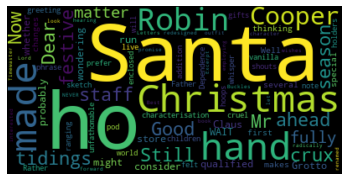

In [182]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  #To hide axis
plt.show()

In [183]:
# getting ntlk gutenberg novel words
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [184]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [185]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [186]:
# This will join all the words together
word_list = [''.join(word) for word in example_corpus]

# To join words as novel/sentences
novel_as_string = ' '.join(word_list)

In [187]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

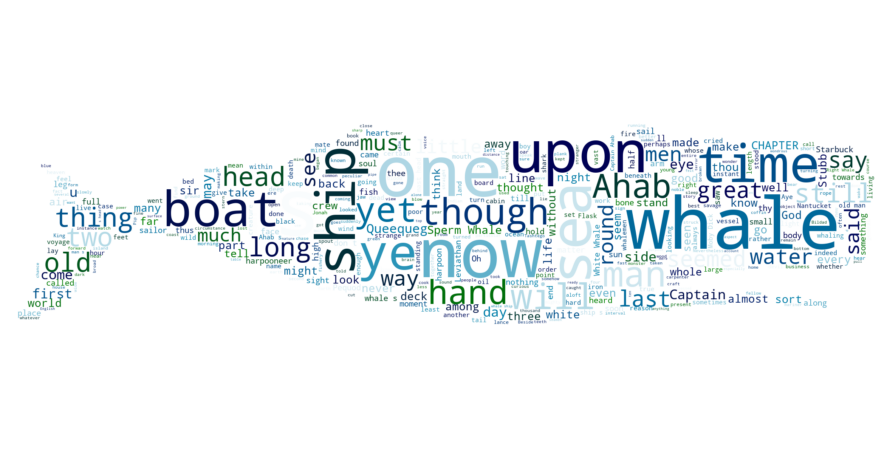

In [188]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #convert img obj to arr

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  #To hide axis
plt.show()

In [189]:
rgb_array.shape   #height,width,rgb

(1024, 2048, 3)

In [190]:
rgb_array[10]    #particular pixel value

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [191]:
# Challenge: User the skull image to create a word cloud
# for shakespeare's play Hamlet

In [192]:
# getting ntlk gutenberg novel words
example_corpus_2 = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
len(example_corpus_2)

37360

In [193]:
# This will join all the words together
word_list_2 = [''.join(word) for word in example_corpus_2]

# To join words as novel/sentences
novel_as_string_2 = ' '.join(word_list_2)

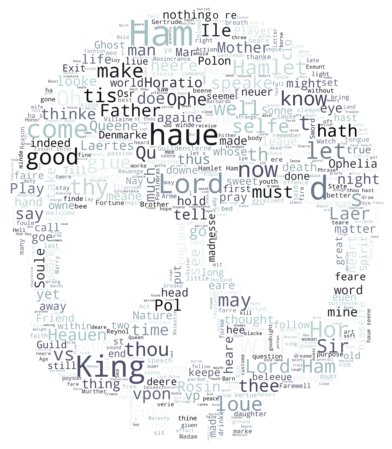

In [194]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #convert img obj to arr

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=600, colormap='bone')
word_cloud.generate(novel_as_string_2)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  #To hide axis
plt.show()

# Word Cloud for Ham and Spam Messages

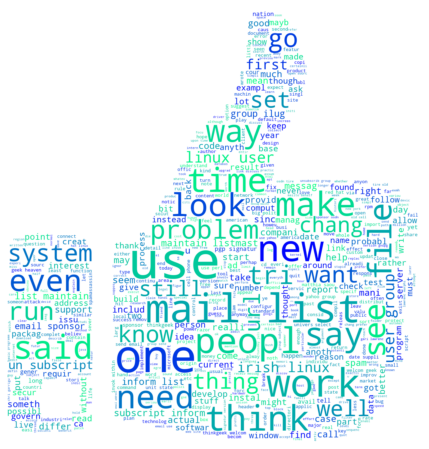

In [195]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #convert img obj to arr

#Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=600, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  #To hide axis
plt.show()

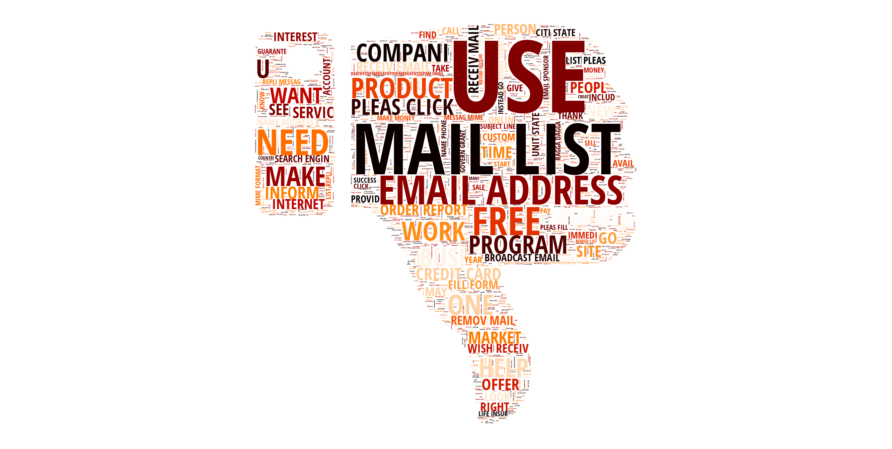

CPU times: user 43.8 s, sys: 11.2 s, total: 55 s
Wall time: 55 s


In [196]:
%%time

# Challenge: use custom font on word cloud
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #convert img obj to arr

#Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=2000, colormap='gist_heat',
                       font_path = CUSTOM_FONT_FILE, max_font_size=300)
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')  #To hide axis
plt.show()

# Generate Vocabulary & Dictionary

In [197]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/Users/faiqueali/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [198]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words:', unique_words.shape[0])
unique_words.head()

Nr of unique words: 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [199]:
# Challenge: Create subset of the series called 'frequent_words' that contains
# the most common 2,500 words out of 27334. Print top 10 words

In [200]:
frequent_words = unique_words[0:VOCAB_SIZE]   #Setting starting and ending point here
print('Most common words: \n', frequent_words[:10])  #From beginning to the end point

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


In [201]:
type(frequent_words)

pandas.core.series.Series

## Create Vocabulary DataFrame with a WORD_ID

In [202]:
word_ids = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [203]:
vocab.to_csv(WORD_ID_FILE, 
             index_label=vocab.index.name,  #WORD_ID
             header=vocab.VOCAB_WORD.name)  #VOCAB_WORD

# Exercise: Checking if a Word is Part of the Vocabulary

In [204]:
# Challenge: Write a line of code that checks if a particular word is part of the vocabulary.
# Code should return true if the word is among the 2,500 words and return False otherwise.
# Check these words: machine, learning, fun, lear, data, science, app, brewery

In [205]:
# Method 1 -inefficient
any(vocab.VOCAB_WORD == 'machine')

False

In [206]:
# Method 2 -better way when large set, time efficient
'http' in set(vocab.VOCAB_WORD)

True

# Exercise: Find the Email with the Most Number of Words

In [207]:
# Challenge: Print out the number of words in the longest email(after cleaning and stemming)
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data frame.

# Hint: Use len() and practice list comprehension

In [208]:
# Method :01 -Using For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))
    
# Longest email words 
longest_email_words = np.max(clean_email_lengths)
print('Longest email words:',longest_email_words)

# Index of longest email words
print('Longest email words index:',clean_email_lengths.index(longest_email_words))

Longest email words: 7671
Longest email words index: 5401


In [209]:
# Method:02- Python list Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]

# Longest email words 
print('Longest email words:',max(clean_email_lengths))

# Index of longest email words
print('Longest email words index:',np.argmax(clean_email_lengths))

Longest email words: 7671
Longest email words index: 5401


In [210]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp